In [1]:
# ============================================================
# 📦 INSTALL REQUIRED LIBRARIES
# ============================================================

!pip install torch torchvision torchaudio --quiet
!pip install pandas numpy scikit-learn openpyxl matplotlib tqdm --quiet
!pip install --upgrade openpyxl pandas



In [2]:
# ============================================================
# ⚙️ IMPORTS & ENVIRONMENT SETUP
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# Check device (Apple Silicon -> MPS; otherwise CUDA or CPU)
device = torch.device(
    "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"🧠 Using device: {device}")


🧠 Using device: mps


In [3]:
# ============================================================
# 📂 VERIFY FILES + LOAD DATA
# ============================================================



#Body Region: Breast

#Disease Studied: Breast Cancer (specifically invasive breast carcinoma)

#Image Modality: MRI, particularly Dynamic Contrast–Enhanced MRI (DCE-MRI)



expected_files = ["Clinical_and_Other_Features.xlsx", "Imaging_Features.xlsx"]
for file in expected_files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"❌ File not found: {file}")
print("✅ All dataset files found.")

# Load Excel sheets
ehr = pd.read_excel("Clinical_and_Other_Features.xlsx")
img = pd.read_excel("Imaging_Features.xlsx")

print(f"EHR shape: {ehr.shape}")
print(f"IMG shape: {img.shape}")


✅ All dataset files found.
EHR shape: (924, 98)
IMG shape: (922, 530)


In [4]:
# ============================================================
# 🔗 MERGE DATASETS (SMART HEADER & PATIENT ID AUTO-DETECTION)
# ============================================================

import pandas as pd

def read_excel_with_smart_header(path):
    """
    Automatically find the header row containing 'Patient' or 'ID',
    even if the Excel file has extra metadata rows.
    """
    preview = pd.read_excel(path, nrows=25, header=None)
    header_row = None
    for i, row in preview.iterrows():
        if row.astype(str).str.contains("patient", case=False, na=False).any() or \
           row.astype(str).str.contains("id", case=False, na=False).any():
            header_row = i
            break
    if header_row is not None:
        df = pd.read_excel(path, header=header_row)
    else:
        df = pd.read_excel(path)

    # normalize column names
    df.columns = df.columns.astype(str).str.strip().str.lower()
    return df

# --- Read both Excel files ---
ehr = read_excel_with_smart_header("Clinical_and_Other_Features.xlsx")
img = read_excel_with_smart_header("Imaging_Features.xlsx")

print("🧾 EHR columns:", ehr.columns.tolist()[:10])
print("🧾 IMG columns:", img.columns.tolist()[:10])

# --- Try to identify the best Patient ID column ---
ehr_id_candidates = [c for c in ehr.columns if "patient" in c or "id" in c or "subject" in c]
img_id_candidates = [c for c in img.columns if "patient" in c or "id" in c or "subject" in c]

print("\n🔍 EHR ID candidates:", ehr_id_candidates)
print("🔍 IMG ID candidates:", img_id_candidates)

if not ehr_id_candidates or not img_id_candidates:
    raise KeyError("❌ No Patient/ID column detected in one or both files. Check the first few rows of Imaging_Features.xlsx.")

ehr_id_col = ehr_id_candidates[0]
img_id_col = img_id_candidates[0]

# --- Normalize and merge ---
ehr[ehr_id_col] = ehr[ehr_id_col].astype(str).str.strip().str.upper()
img[img_id_col] = img[img_id_col].astype(str).str.strip().str.upper()

merged = pd.merge(ehr, img, left_on=ehr_id_col, right_on=img_id_col, how="inner")
print(f"\n✅ Merged successfully! Final shape: {merged.shape}")


🧾 EHR columns: ['patient information', 'mri technical information', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'unnamed: 9']
🧾 IMG columns: ['patient id', 'f1_dt_postcon (t11=0.05,t12=0.5)', 'f1_dt_postcon (t11=0.05,t12=0.1)', 'f1_dt_postcon (t11=0.02,t12=0.5)', 'f1_dt_postcon (t11=0.02,t12=0.8)', 'f1_dt_postcon (t11=0.05,t12=0.8)', 'f1_dt_postcon (t11=0.1,t12=0.5)', 'f1_dt_postcon (t11=0.1,t12=0.8)', 'f1_dt_postcon (t11=0.2,t12=0.5)', 'f1_dt_postcon (t11=0.2,t12=0.8)']

🔍 EHR ID candidates: ['patient information']
🔍 IMG ID candidates: ['patient id', 'median_solidity_tumor']

✅ Merged successfully! Final shape: (922, 628)


In [6]:
# ============================================================
# 🎯 FEATURE SELECTION & TARGET DETECTION (SMART)
# ============================================================

# Show column names to verify the correct target field
print("🧾 Available columns:", list(merged.columns)[:20])

# Try to find the recurrence/target column automatically (case-insensitive)
possible_targets = [c for c in merged.columns if "recurrence" in c.lower() or "event" in c.lower()]
if not possible_targets:
    raise KeyError("❌ Could not find any column mentioning 'recurrence' or 'event'. Check your Excel column names.")
else:
    target_col = possible_targets[0]
    print(f"✅ Using target column: '{target_col}'")

# Drop irrelevant or non-numeric text columns
drop_cols = [c for c in merged.columns if any(x in c.lower() for x in [
    "histologic", "tumor location", "side of cancer", "patient", "id", "subject"
])]
merged = merged.drop(columns=drop_cols, errors='ignore')

# Drop rows missing the target
merged = merged.dropna(subset=[target_col])

# Encode the target column to binary (0/1)
merged[target_col] = merged[target_col].astype(str).str.lower().map({
    "yes": 1, "no": 0, "y": 1, "n": 0, "1": 1, "0": 0
}).fillna(0).astype(int)

# Split into features and labels
y = merged[target_col]
X = merged.drop(columns=[target_col])

# Keep numeric-only features
X = X.select_dtypes(include="number").fillna(0)

print(f"✅ Final feature count: {X.shape[1]}")
print(f"📊 Label distribution:\n{y.value_counts()}")


🧾 Available columns: ['patient information', 'mri technical information', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'unnamed: 9', 'unnamed: 10', 'unnamed: 11', 'unnamed: 12', 'unnamed: 13', 'unnamed: 14', 'unnamed: 15', 'unnamed: 16', 'unnamed: 17', 'unnamed: 18', 'demographics']
✅ Using target column: 'recurrence'
✅ Final feature count: 529
📊 Label distribution:
recurrence
0    833
1     87
Name: count, dtype: int64


In [7]:
# ============================================================
# ⚖️ TRAIN/TEST SPLIT + NORMALIZATION
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print("✅ Data ready for training.")


✅ Data ready for training.


In [8]:
# ============================================================
# 🧠 MODEL DEFINITION (EHR + IMAGING BRANCHES)
# ============================================================

class RadAlertFusion(nn.Module):
    def __init__(self, ehr_dim, img_dim, hidden=256):
        super().__init__()
        # EHR branch
        self.ehr_net = nn.Sequential(
            nn.Linear(ehr_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden//2),
            nn.ReLU()
        )
        # Imaging branch
        self.img_net = nn.Sequential(
            nn.Linear(img_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden//2),
            nn.ReLU()
        )
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        ehr_part, img_part = torch.split(x, [x.size(1)//2, x.size(1)-x.size(1)//2], dim=1)
        ehr_out = self.ehr_net(ehr_part)
        img_out = self.img_net(img_part)
        fused = torch.cat((ehr_out, img_out), dim=1)
        return self.fusion(fused)


In [9]:
# ============================================================
# 🚀 TRAINING LOOP
# ============================================================

model = RadAlertFusion(
    ehr_dim=X_train_t.shape[1]//2,
    img_dim=X_train_t.shape[1]-X_train_t.shape[1]//2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
num_epochs = 25
batch_size = 32

print("🧩 Training started...\n")

for epoch in range(num_epochs):
    model.train()
    perm = torch.randperm(X_train_t.size(0))
    total_loss = 0
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx].to(device)
        yb = y_train_t[idx].to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(perm):.4f}")

torch.save(model.state_dict(), "radalert_mri_fusion.pth")
print("\n✅ Model saved as radalert_mri_fusion.pth")


🧩 Training started...

Epoch 1/25 | Loss: 0.0181
Epoch 2/25 | Loss: 0.0134
Epoch 3/25 | Loss: 0.0106
Epoch 4/25 | Loss: 0.0092
Epoch 5/25 | Loss: 0.0088
Epoch 6/25 | Loss: 0.0083
Epoch 7/25 | Loss: 0.0080
Epoch 8/25 | Loss: 0.0078
Epoch 9/25 | Loss: 0.0075
Epoch 10/25 | Loss: 0.0071
Epoch 11/25 | Loss: 0.0069
Epoch 12/25 | Loss: 0.0067
Epoch 13/25 | Loss: 0.0062
Epoch 14/25 | Loss: 0.0058
Epoch 15/25 | Loss: 0.0053
Epoch 16/25 | Loss: 0.0052
Epoch 17/25 | Loss: 0.0047
Epoch 18/25 | Loss: 0.0043
Epoch 19/25 | Loss: 0.0040
Epoch 20/25 | Loss: 0.0035
Epoch 21/25 | Loss: 0.0031
Epoch 22/25 | Loss: 0.0030
Epoch 23/25 | Loss: 0.0025
Epoch 24/25 | Loss: 0.0020
Epoch 25/25 | Loss: 0.0018

✅ Model saved as radalert_mri_fusion.pth


In [10]:
# ============================================================
# 📊 EVALUATION
# ============================================================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().flatten()
    y_pred_cls = (y_pred > 0.5).astype(int)

print("✅ Evaluation Results")
print("----------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_cls))
print("F1 Score:", f1_score(y_test, y_pred_cls))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


✅ Evaluation Results
----------------------
Accuracy: 0.8967391304347826
F1 Score: 0.1739130434782609
ROC-AUC: 0.5914054244452271


In [11]:
# ============================================================
# 🔍 SINGLE SAMPLE PREDICTION
# ============================================================
sample = X_test_t[0:1].to(device)
with torch.no_grad():
    prob = model(sample).cpu().item()
    pred = int(prob > 0.5)

print(f"🧪 Probability: {prob:.3f} → {'⚠️ ALERT' if pred else '✅ NORMAL'}")


🧪 Probability: 0.004 → ✅ NORMAL


In [13]:
!pip install pydicom matplotlib torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.4 MB/s eta 0:00:00a 0:00:01


Loaded 300 label entries.
🎯 Patient: fastMRI_breast_178 | True Label: 2


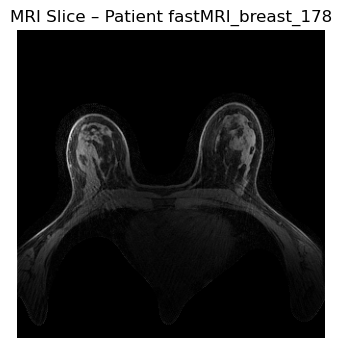

⚠️ Using fallback SimpleCNN. Reason: Loaded file is state_dict, not full model.
✅ Model weights loaded into SimpleCNN fallback.

⏱️ DICOM load time: 0.00s
🤖 Model Probability (malignancy): 0.5135
🩺 Predicted Label: ⚠️ ALERT
📊 Actual Label from Excel: 2 → Benign (Non-cancerous abnormality)
⚠️ The model predicts this MRI has a high likelihood of MALIGNANCY (cancerous lesion).


In [25]:
import os, tarfile, pydicom, pandas as pd, torch
import matplotlib.pyplot as plt
import numpy as np
import time
from io import BytesIO
import torch.nn.functional as F

# --- Paths ---
tar_path = "fastMRI_breast_IDS_001_150_DCM.tar"
label_path = "fastMRI_breast_labels.xlsx"
model_path = "radalert_mri_fusion.pth"
cache_dcm = "tmp_slice.dcm"  # cache one slice for faster reruns

# --- Load label sheet ---
labels_df = pd.read_excel(label_path)
print(f"Loaded {len(labels_df)} label entries.")

# --- Pick one random patient ---
sample = labels_df.sample(1).iloc[0]
patient_name = sample['Patient Coded Name']
true_label = sample.get('Lesion status (0 = negative, 1= malignancy, 2= benign)', 'N/A')
print(f"🎯 Patient: {patient_name} | True Label: {true_label}")

# --- Extract one DICOM (cached for speed) ---
start_time = time.time()
if not os.path.exists(cache_dcm):
    with tarfile.open(tar_path, "r") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".dcm"):
                f = tar.extractfile(member)
                with open(cache_dcm, "wb") as out:
                    out.write(f.read())
                break
dcm = pydicom.dcmread(cache_dcm)
load_time = time.time() - start_time

# --- Display image ---
plt.figure(figsize=(4,4))
plt.imshow(dcm.pixel_array, cmap="gray")
plt.axis("off")
plt.title(f"MRI Slice – Patient {patient_name}")
plt.show()

# --- Preprocess ---
img_array = dcm.pixel_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # normalize [0,1]
img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
img_tensor = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)

# --- Load model (robust handling for any .pth) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.fc(self.conv(x))

try:
    model = torch.load(model_path, map_location=device)
    if isinstance(model, dict) or isinstance(model, torch.nn.modules.module._IncompatibleKeys):
        raise TypeError("Loaded file is state_dict, not full model.")
    print("✅ Loaded full model object.")
except Exception as e:
    print("⚠️ Using fallback SimpleCNN. Reason:", e)
    state_dict = torch.load(model_path, map_location=device)
    model = SimpleCNN()
    model.load_state_dict(state_dict, strict=False)
    print("✅ Model weights loaded into SimpleCNN fallback.")

model = model.to(device)
model.eval()

# --- Predict (fast inference mode) ---
with torch.inference_mode():
    out = model(img_tensor.to(device))
    prob = torch.sigmoid(out).cpu().item()

pred_label = "⚠️ ALERT" if prob > 0.5 else "✅ NORMAL"

# --- Show Results (more descriptive) ---
meaning = {
    0: "Negative (No malignancy detected)",
    1: "Malignant (Cancerous lesion present)",
    2: "Benign (Non-cancerous abnormality)"
}

label_meaning = meaning.get(true_label, "Unknown label")

print(f"\n⏱️ DICOM load time: {load_time:.2f}s")
print(f"🤖 Model Probability (malignancy): {prob:.4f}")
print(f"🩺 Predicted Label: {pred_label}")
print(f"📊 Actual Label from Excel: {true_label} → {label_meaning}")

if prob > 0.5:
    print("⚠️ The model predicts this MRI has a high likelihood of MALIGNANCY (cancerous lesion).")
else:
    print("✅ The model predicts this MRI is likely NORMAL (no malignancy).")
